In [ ]:
# import libraries and packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import comb
import os
import tqdm


In [4]:
# read in dataframe
df = pd.read_csv("../073025_final_df.tsv", sep="\t", index_col=False)
# Drop columns: 'Unnamed: 0.4', 'Unnamed: 0.3' and 3 other columns
# df = df.drop(columns=['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'])

df['source'] = 'all'
df['Log Length'] = np.log10(df['Size (bp)'])
# filter for only plasmids with less than 150 IS
df = df[df["num_IS"]<150]
# control for size
# df = df[(df["Size (bp)"]<196000) & (df["Size (bp)"]>136000)]
df = df[df["Size (bp)"]>50000]


# subset of 1000 plasmids
with open("../062725.inputs.1000.txt", "r") as f:
    subset = [line.strip() for line in f if line.strip()]
# multiple ORIs
mul_ORIs_df = pd.read_csv("../heterodimer/mORIs.df.tsv", sep="\t")
mul_ORIs_df = mul_ORIs_df[mul_ORIs_df.Type==1]
mul_ORIs = mul_ORIs_df.seqID.unique()
# mORI_df: dataframe with only multiple ORI plasmids
mORI_df = df[df["Plasmid_ID"].isin(mul_ORIs)]
df.loc[df["Plasmid_ID"].isin(mORI_df["Plasmid_ID"]), "source"] = "mORI"
# heterodimers
with open("../heterodimer/heterodimer-plasmids-all.txt", "r") as f:
    heterodimers = list(set([line.strip() for line in f if line.strip()]))
# heterodimers_df: dataframe with only TOTOs
TOTO_df = df[df["Plasmid_ID"].isin(heterodimers)]
df.loc[df["Plasmid_ID"].isin(TOTO_df["Plasmid_ID"]), "source"] = "TOTO"

# add a column to each DataFrame to identify the group
df["group"] = "All"
mORI_df["group"] = "mORI"
TOTO_df["group"] = "TOTO"
# combine all into one DataFrame
combined_df = pd.concat([df, mORI_df, TOTO_df])

# print(df.columns)
# df.to_csv("../final_df_AMRs.tsv", sep="\t", index=False)

/tmp/ipykernel_565283/3334061401.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mORI_df["group"] = "mORI"
/tmp/ipykernel_565283/3334061401.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TOTO_df["group"] = "TOTO"


In [ ]:
# plotting length distribution
# plasmid_lengths = sns.FacetGrid(combined_df, col="num_ORIs", hue="group")
# plasmid_lengths.map(sns.histplot, "Log Length", bins=200, kde=True)
palette = sns.color_palette("deep")
plasmid_lengths = sns.histplot(data=combined_df, x="Log Length", bins=200, kde=True, hue="group", palette=palette) #everything
plt.show()

# avg lengths?
avg_all=round(np.average(df["Size (bp)"]))
avg_mORIs=round(np.average(mORI_df["Size (bp)"]))
avg_TOTOs=round(np.average(TOTO_df["Size (bp)"]))
print(f"avg all: {avg_all}\navg mORIs: {avg_mORIs}\navg TOTOs: {avg_TOTOs}")


In [ ]:
# finding p-values for length distributions (mORI non-exclusive of TOTOs)

sample_mORIs = np.random.choice(range(1,len(mORI_df)), size=10000,replace=True)
sample_TOTOs = np.random.choice(range(1,len(TOTO_df)), size=10000,replace=True)
count_mORI = 0
count_TOTO = 0
for i in range(10000):
    len_mORI = mORI_df["Size (bp)"].iat[sample_mORIs[i]]
    len_TOTO = TOTO_df["Size (bp)"].iat[sample_TOTOs[i]]
    if len_mORI > len_TOTO:
        count_mORI+=1
    else:
        count_TOTO+=1
pval = count_mORI/(count_mORI+count_TOTO)
print(f"mORIs: {count_mORI}\nTOTOs: {count_TOTO}\npval: {pval}")

In [ ]:
# finding p-values for length distributions (mORI exclusive of TOTOs)

mORI_exclusive_df = mORI_df[~(mORI_df["Plasmid_ID"].isin(heterodimers))]

sample_mORIs = np.random.choice(range(1,len(mORI_exclusive_df)), size=10000,replace=True)
sample_TOTOs = np.random.choice(range(1,len(TOTO_df)), size=10000,replace=True)
count_mORI = 0
count_TOTO = 0
for i in range(10000):
    len_mORI = mORI_df["Size (bp)"].iat[sample_mORIs[i]]
    len_TOTO = TOTO_df["Size (bp)"].iat[sample_TOTOs[i]]
    if len_mORI > len_TOTO:
        count_mORI+=1
    else:
        count_TOTO+=1
pval = count_mORI/(count_mORI+count_TOTO)
print(f"mORIs: {count_mORI}\n TOTOs: {count_TOTO}\npval: {pval}")

In [ ]:
# AMR binary plot (does a plasmid have or not have AMR genes)

# filter by num ORI/IS
filtered_df = df
filtered_df = df[df["num_ORIs"]==4]
# filtered_df = df[df["num_IS"] < 50]
# dfs
AMRs_mORI = filtered_df[filtered_df["source"]=="mORI"]
AMRs_TOTO = filtered_df[filtered_df["source"]=="TOTO"]

# side by side comparsion of different categories (mORI exclusive of TOTOs)
all_AMR_frac = len(filtered_df[filtered_df["AMR_binary"]==1])/len(filtered_df)
mORI_AMR_frac = len(AMRs_mORI[AMRs_mORI["AMR_binary"]==1])/len(AMRs_mORI)
TOTO_AMR_frac = len(AMRs_TOTO[AMRs_TOTO["AMR_binary"]==1])/len(AMRs_TOTO)
AMR_df = pd.DataFrame({
    "Group": ["All", "mORIs", "TOTOs"],
    "Proportion containing AMRs": [all_AMR_frac, mORI_AMR_frac, TOTO_AMR_frac]
})
amr_bar = sns.barplot(data=AMR_df, x="Group", y="Proportion containing AMRs", palette=palette)
plt.show()
print(f"all: {round(all_AMR_frac,3)}\nmORI: {round(mORI_AMR_frac,3)}\nTOTO: {round(TOTO_AMR_frac,3)}")

# randomly sample 1000 (for size control)
# sampled_df = df.sample(n=900)
# sampled_mORI_df = AMRs_mORI.sample(n=900)
# sampled_TOTO_df = AMRs_TOTO.sample(n=900)

# all_AMR_frac = len(sampled_df[sampled_df["AMR_binary"]==1])/len(sampled_df)
# mORI_AMR_frac = len(sampled_mORI_df[sampled_mORI_df["AMR_binary"]==1])/len(sampled_mORI_df)
# TOTO_AMR_frac = len(sampled_TOTO_df[sampled_TOTO_df["AMR_binary"]==1])/len(sampled_TOTO_df)
# AMR_df = pd.DataFrame({
#     "Group": ["All", "mORIs", "TOTOs"],
#     "Propotion containing AMRs": [all_AMR_frac, mORI_AMR_frac, TOTO_AMR_frac]
# })
# sns.barplot(data=AMR_df, x="Group", y="Propotion containing AMRs")
# plt.show()
# print(f"all: {round(all_AMR_frac,3)}\nmORI: {round(mORI_AMR_frac,3)}\nTOTO: {round(TOTO_AMR_frac,3)}")


# AMR statistical analysis (bootstrapping)
all_fracs = []
mORI_fracs = []
TOTO_fracs = []

for i in range(100):
    sample_all = np.random.choice(range(1,len(df)), size=len(df),replace=True)
    count_all = 0
    sample_mORIs = np.random.choice(range(1,len(AMRs_mORI)), size=len(AMRs_mORI),replace=True)
    count_mORI = 0
    sample_TOTOs = np.random.choice(range(1,len(AMRs_TOTO)), size=len(AMRs_TOTO),replace=True)
    count_TOTO = 0
    for j in range(len(df)):
        amr_all = df["AMR_binary"].iat[sample_all[j]]
        if amr_all:
            count_all+=1
    for j in range(len(AMRs_mORI)):
        amr_mORI = AMRs_mORI["AMR_binary"].iat[sample_mORIs[j]]
        if amr_mORI:
            count_mORI+=1
    for j in range(len(AMRs_TOTO)):
        amr_TOTO = TOTO_df["AMR_binary"].iat[sample_TOTOs[j]]
        if amr_TOTO:
            count_TOTO+=1
    all_fracs.append(count_all/len(df))
    mORI_fracs.append(count_mORI/len(AMRs_mORI))
    TOTO_fracs.append(count_TOTO/len(AMRs_TOTO))

# print(f"all: {all_fracs}\nmORIs: {mORI_fracs}\nTOTOs: {TOTO_fracs}")

# plotting variance
avg_AMR_all = np.mean(all_fracs)
avg_AMR_mORI = np.mean(mORI_fracs)
avg_AMR_TOTO = np.mean(TOTO_fracs)
data = [all_fracs,mORI_fracs,TOTO_fracs]
amr_perc_df = pd.DataFrame({
    "Percent": all_fracs + mORI_fracs + TOTO_fracs,
    "Group": ["All"] * len(all_fracs) + ["mORIs"] * len(mORI_fracs) + ["TOTOs"] * len(TOTO_fracs)
})
ax = sns.stripplot(data=amr_perc_df, x="Group", y="Percent", jitter=True, alpha=0.5, color="black")
means = amr_perc_df.groupby("Group")["Percent"].mean().reset_index()
sns.pointplot(data=means, x="Group", y="Percent", join=False, markers="D", color="red", scale=1.2, errwidth=0)
plt.tight_layout()
plt.show()

# plot with error bars
groups = ["All", "mORIs", "TOTOs"]
bootstrap_data = [all_fracs, mORI_fracs, TOTO_fracs]
# compute mean and std
summary = pd.DataFrame({
    "Group": groups,
    "Proportion containing AMRs": [np.mean(d) for d in bootstrap_data],
    "Error": [np.std(d) for d in bootstrap_data]
})
# Plot with manual error bars
sns.barplot(data=summary, x="Group", y="Proportion containing AMRs", palette="deep", errorbar=None)
# Add custom error bars
plt.errorbar(x=np.arange(len(summary)), y=summary["Proportion containing AMRs"], yerr=summary["Error"], fmt='none', ecolor='black', capsize=5, linewidth=1.5)
plt.tight_layout()
plt.show()

In [ ]:
# # distribution of the number of ORIs and IS for each type

# dodged plot of num ORIs
sns.histplot(data=combined_df, x="num_ORIs", hue="group", binwidth=1, multiple="dodge", shrink=0.8)
plt.show()
sub = combined_df[combined_df["group"]!="All"]
sns.histplot(data=sub, x="num_ORIs", hue="group", binwidth=1, multiple="dodge", shrink=0.8)
plt.show()

# # individual plots of num ORIs
# # all_num_ORIs = sns.histplot(data=df, x="num_ORIs", color="blue", binwidth=1)
# # plt.show()
# mORI_num_ORIs = sns.histplot(data=mORI_df, x="num_ORIs", color="green", binwidth=1)
# plt.show()
# TOTO_num_ORIs = sns.histplot(data=TOTO_df, x="num_ORIs", color="red", binwidth=1)
# plt.show()

IS_df = combined_df[combined_df["num_IS"] > 0]
# dodged plot of num IS
sns.histplot(data=IS_df, x="num_IS", hue="group", binwidth=15, multiple="dodge")
plt.show()

# individual plots of num IS
all_IS_df = IS_df[IS_df["group"]=="All"]
all_num_IS = sns.histplot(data=IS_df, x="num_IS", color="blue", binwidth=5)
plt.show()
mORI_IS_df = IS_df[IS_df["group"]=="mORI"]
mORI_num_IS = sns.histplot(data=mORI_IS_df, x="num_IS", color="green", binwidth=5)
plt.show()
TOTO_IS_df = IS_df[IS_df["group"]=="TOTO"]
TOTO_num_IS = sns.histplot(data=TOTO_IS_df, x="num_IS", color="red", binwidth=5)
plt.show()

# scatterplot of num ORIs vs num IS
# sns.scatterplot(data=sub, x="num_ORIs", y="num_IS", hue="group", alpha=0.5)
# plt.show()

sns.scatterplot(data=df, x="num_ORIs", y="num_IS", alpha=0.5, color="blue")
plt.show()
sns.scatterplot(data=mORI_df, x="num_ORIs", y="num_IS", alpha=0.5, color="green")
plt.show()
sns.scatterplot(data=TOTO_df, x="num_ORIs", y="num_IS", alpha=0.5, color="red")
plt.show()

In [ ]:
# ORI analysis
ORI_abs_freq = pd.read_csv("../heterodimer/ORIs.abs.freq.tsv", sep="\t", index_col=False)

# Calculate expected values of cooccurence
# ORI_abs_freq["percent_freq"] = ORI_abs_freq["count"]/len(ORI_abs_freq)
# matrix = np.zeros((len(ORI_abs_freq), len(ORI_abs_freq)))
# # write a for loop iterating through every pair and calculating the expected value
# for i in tqdm(range(len(ORI_abs_freq["ORI"]))):
#     for j in tqdm(range(i,len(ORI_abs_freq["ORI"]))):
#         matrix[i,j] = ORI_abs_freq["percent_freq"].iat[i] * ORI_abs_freq["percent_freq"].iat[j]
        

# Distribution of ORIs
ORI_abs_freq = ORI_abs_freq[ORI_abs_freq["count"]>1000]
print(ORI_abs_freq["ORI"])
sns.barplot(data=ORI_abs_freq, x="ORI", y="count")
plt.xticks(rotation=45)  # optional: rotate x-axis labels if needed
plt.show()

[21693, 5159, 8881]


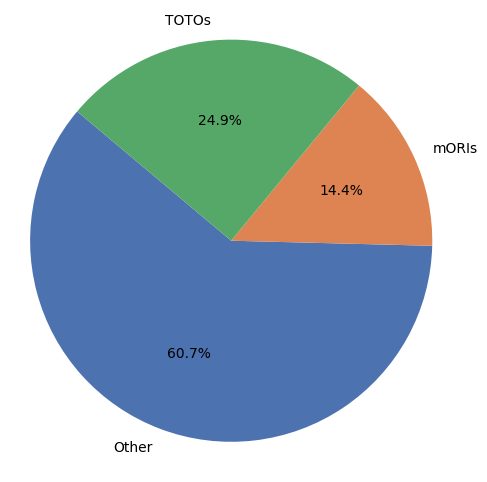

In [5]:
# pie chart showing the prevalence of each group
other = len(df[df["source"]=="all"])
mORIs = len(df[df["source"]=="mORI"])
TOTOs = len(df[df["source"]=="TOTO"])
labels = ["Other", "mORIs", "TOTOs"]
prevalence = [other, mORIs, TOTOs]
print(prevalence)
# use Seaborn palette
colors = sns.color_palette("deep")[:len(labels)]
# Create pie chart
plt.figure(figsize=(5,5))
plt.pie(prevalence, labels=labels, colors=colors, autopct="%1.1f%%", startangle=140)
plt.axis("equal")  # Equal aspect ratio ensures a circle
plt.tight_layout()
plt.show()

In [ ]:
# Distribution of the num AMRs
filtered_num_AMRs = combined_df
# filtered_num_AMRs = combined_df[combined_df["num_AMRs"]<15]
# filtered_num_AMRs = filtered_num_AMRs[filtered_num_AMRs["group"]!="All"]

palette = sns.color_palette("deep")
plasmid_lengths = sns.catplot(data=filtered_num_AMRs, x="group", y="num_AMRs", palette=palette, kind="violin", cut=0) # everything
plt.show()

# avg lengths?
all_AMR_df = filtered_num_AMRs[filtered_num_AMRs["group"]=="All"]
avg_all=round(np.median(all_AMR_df["num_AMRs"]),2)
mORI_AMR_df = filtered_num_AMRs[filtered_num_AMRs["group"]=="mORI"]
avg_mORIs=round(np.median(mORI_AMR_df["num_AMRs"]),2)
TOTO_AMR_df = filtered_num_AMRs[filtered_num_AMRs["group"]=="TOTO"]
avg_TOTOs=round(np.median(TOTO_AMR_df["num_AMRs"]),2)
print(f"avg all: {avg_all}\navg mORIs: {avg_mORIs}\navg TOTOs: {avg_TOTOs}")

In [ ]:
# scratch cell
matrix_df = pd.read_csv('../heterodimer/GenBank_OQ029473.1.tsv', sep='\t', index_col=False)
matrix = matrix_df.to_numpy()
index = np.where(matrix==1)
print(index)

# heatmap
sns.heatmap(matrix, vmin=0, vmax=1, cmap="viridis")
plt.show()

df = pd.read_csv("../heterodimer/type.1and2.ORIs.identified.tsv", sep="\t")
print(df["qseqid"].nunique())